💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
c:\Users\Melvi\anaconda3\envs\capstone-gpu\Lib\site-packages\pina\trainer.py: UserWarning: Compilation is disabled for Python 3.14+ and for Windows.
c:\Users\Melvi\anaconda3\envs\capstone-gpu\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | _pina_models | ModuleList | 16.9 K | train
1 | _loss_fn     | MSELoss    | 0      | train
----------------------------------------------------
16.9 K    Trainable params
0         Non-trainable params
1

>>> starting training


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


>>> training finished
>>> u stats on random sample: min=-0.009, max=1.020, mean=0.526


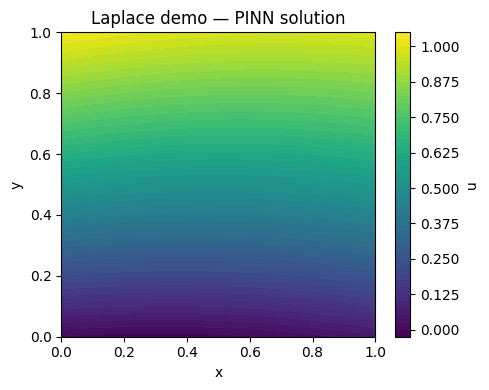

>>> plotted solution


In [3]:
import torch, matplotlib.pyplot as plt
from pina.domain import CartesianDomain
from pina import Condition
from pina.equation import Laplace, FixedValue
from pina.model import FeedForward
from pina.problem import SpatialProblem
from pina.solver.physics_informed_solver import PINN
from pina.trainer import Trainer

# --- Simple Laplace problem (same as before) ---
class SimpleLaplace(SpatialProblem):
    output_variables = ['u']
    spatial_domain = CartesianDomain({'x':[0,1],'y':[0,1]})
    domains = {
        'D': CartesianDomain({'x':[0,1],'y':[0,1]}),
        'top': CartesianDomain({'x':[0,1],'y':1.0}),
        'bottom': CartesianDomain({'x':[0,1],'y':0.0}),
    }
    conditions = {
        'pde': Condition(domain='D', equation=Laplace(components=['u'], d=['x','y'])),
        'top': Condition(domain='top', equation=FixedValue(1.0, components=['u'])),
        'bottom': Condition(domain='bottom', equation=FixedValue(0.0, components=['u'])),
    }

problem = SimpleLaplace()
problem.discretise_domain(n=2000, mode='latin')
problem.discretise_domain(n=200, mode='latin', domains=['top','bottom'])

model = FeedForward(input_dimensions=2, output_dimensions=1, inner_size=64, n_layers=5)
solver = PINN(problem=problem, model=model)

print(">>> starting training")
trainer = Trainer(
    solver=solver,
    max_epochs=100,
    enable_model_summary=True,     # show a brief model summary
    enable_progress_bar=True,      # progress bar in notebook/console
)
trainer.train()
print(">>> training finished")

# --- FORCE some visible output ---
# 1) Print a quick stat of u over 2k random points
pts = problem.spatial_domain.sample(2000, "random")
with torch.no_grad():
    u = solver(pts).tensor.squeeze()
print(f">>> u stats on random sample: min={u.min().item():.3f}, "
      f"max={u.max().item():.3f}, mean={u.mean().item():.3f}")

# 2) Make a small plot (so you can *see* the field)
grid = problem.spatial_domain.sample(60, "grid")
with torch.no_grad():
    ug = solver(grid).tensor.squeeze().cpu()
x = grid.extract("x").tensor.cpu().flatten()
y = grid.extract("y").tensor.cpu().flatten()

plt.figure(figsize=(5,4))
tcf = plt.tricontourf(x, y, ug, levels=50)
plt.colorbar(tcf, label="u")
plt.title("Laplace demo — PINN solution")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()
print(">>> plotted solution")



💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
c:\Users\Melvi\anaconda3\envs\capstone-gpu\Lib\site-packages\pina\trainer.py: UserWarning: Compilation is disabled for Python 3.14+ and for Windows.
c:\Users\Melvi\anaconda3\envs\capstone-gpu\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | _pina_models | ModuleList | 46.9 K | train
1 | _loss_fn     | MSELoss    | 0      | train
----------------------------------------------------
46.9 K    Trainable params
0         Non-trainable params
4

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


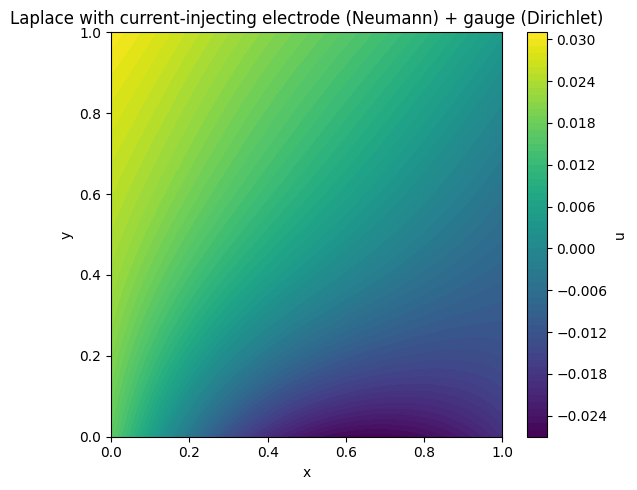

In [4]:
import torch, matplotlib.pyplot as plt
from pina.domain import CartesianDomain
from pina import Condition
from pina.equation import Laplace, FixedValue, Equation
from pina.model import FeedForward
from pina.problem import SpatialProblem
from pina.operator import grad
from pina.solver.physics_informed_solver import PINN
from pina.trainer import Trainer

# --- parameters you can tweak ---
sigma = 1.0               # conductivity (arb. units)
Jn_target = 0.2           # injected normal current density on the electrode
elec_center = 0.5         # electrode x-center in [0,1]
elec_halfw  = 0.03        # electrode half-width
gauge_halfw = 0.10        # small gauge patch on top

# --- Neumann helper: J·n = -sigma * ∇u · n  -> enforce J·n = target ---
def neumann_flux(axis="y", normal_sign=+1, target=0.0, sigma=1.0):
    nx, ny = (1.0, 0.0) if axis == "x" else (0.0, 1.0)
    nx *= normal_sign; ny *= normal_sign
    def residual(input_, output_):
        ux = grad(output_, input_, components=["u"], d=["x"])
        uy = grad(output_, input_, components=["u"], d=["y"])
        # J·n = -sigma*(ux*nx + uy*ny)
        Jn = -(sigma)*(ux + uy*0.0)*0.0  # placeholder to keep LabelTensor math
        Jn = -(sigma)*(ux*nx + uy*ny)
        return Jn - target
    return Equation(residual)

# --- problem with a current-injecting electrode ---
class InjectedLaplace(SpatialProblem):
    output_variables = ["u"]
    spatial_domain = CartesianDomain({"x":[0,1],"y":[0,1]})

    # boundary patches
    x0, x1 = 0.0, 1.0
    y0, y1 = 0.0, 1.0
    elec_lo, elec_hi = elec_center-elec_halfw, elec_center+elec_halfw
    g_lo, g_hi       = 0.5-gauge_halfw, 0.5+gauge_halfw

    domains = {
        "D": CartesianDomain({"x":[x0,x1],"y":[y0,y1]}),

        # bottom: electrode patch (Neumann Jn_target) + insulated remainder
        "electrode":    CartesianDomain({"x":[elec_lo,elec_hi], "y": y0}),
        "bottom_left":  CartesianDomain({"x":[x0, elec_lo],     "y": y0}),
        "bottom_right": CartesianDomain({"x":[elec_hi, x1],     "y": y0}),

        # top: small gauge Dirichlet + insulated remainder
        "gauge":     CartesianDomain({"x":[g_lo, g_hi], "y": y1}),
        "top_left":  CartesianDomain({"x":[x0, g_lo],  "y": y1}),
        "top_right": CartesianDomain({"x":[g_hi, x1],  "y": y1}),

        # side walls insulated
        "left_wall":  CartesianDomain({"x": x0, "y":[y0,y1]}),
        "right_wall": CartesianDomain({"x": x1, "y":[y0,y1]}),
    }

    conditions = {
        # PDE
        "pde": Condition(domain="D", equation=Laplace(components=["u"], d=["x","y"])),

        # Electrode: inject positive Jn into the domain; bottom outward normal is (0,-1)
        # so normal_sign = -1.
        "elec_J": Condition(domain="electrode",
                            equation=neumann_flux(axis="y", normal_sign=-1,
                                                  target=Jn_target, sigma=sigma)),

        # Insulation (zero flux) elsewhere
        "bL_nf": Condition(domain="bottom_left",
                           equation=neumann_flux(axis="y", normal_sign=-1, target=0.0, sigma=sigma)),
        "bR_nf": Condition(domain="bottom_right",
                           equation=neumann_flux(axis="y", normal_sign=-1, target=0.0, sigma=sigma)),
        "tL_nf": Condition(domain="top_left",
                           equation=neumann_flux(axis="y", normal_sign=+1, target=0.0, sigma=sigma)),
        "tR_nf": Condition(domain="top_right",
                           equation=neumann_flux(axis="y", normal_sign=+1, target=0.0, sigma=sigma)),
        "l_nf":  Condition(domain="left_wall",
                           equation=neumann_flux(axis="x", normal_sign=-1, target=0.0, sigma=sigma)),
        "r_nf":  Condition(domain="right_wall",
                           equation=neumann_flux(axis="x", normal_sign=+1, target=0.0, sigma=sigma)),

        # Gauge: tiny Dirichlet patch to fix the reference.
        "gauge0": Condition(domain="gauge", equation=FixedValue(0.0, components=["u"])),
    }

# --- discretize, train, show something ---
problem = InjectedLaplace()

# interior + boundaries
problem.discretise_domain(6000, "latin", domains=["D"])
for name in ["electrode","bottom_left","bottom_right","top_left","top_right","left_wall","right_wall","gauge"]:
    n = 800 if name in ["electrode","gauge"] else 400
    problem.discretise_domain(n, "latin", domains=[name])

model = FeedForward(input_dimensions=2, output_dimensions=1, inner_size=96, n_layers=6)
solver = PINN(problem=problem, model=model)
trainer = Trainer(solver=solver, max_epochs=200)
trainer.train()

# quick visual
grid = problem.spatial_domain.sample(80, "grid")
with torch.no_grad():
    u = solver(grid).tensor.squeeze().cpu()
x = grid.extract("x").tensor.cpu().flatten()
y = grid.extract("y").tensor.cpu().flatten()
plt.figure(figsize=(6,5))
tcf = plt.tricontourf(x,y,u,levels=60); plt.colorbar(tcf,label="u")
plt.title("Laplace with current-injecting electrode (Neumann) + gauge (Dirichlet)")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout(); plt.show()
